<a href="https://colab.research.google.com/github/k-perez/Chandra-Pipeline/blob/master/CK_turboSETI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This tutorial was put together by Karen Perez and Carmen Choza.
#### This tutorial largely draws from previous tutorials made, specifically Richard Elkins' tutorials on the main Github page for turboSETI (https://github.com/UCBerkeleySETI/turbo_seti/tree/master/tutorial), Elan Lavie's tutorial based on an old version of turboSETI (https://github.com/elanlavie/VoyagerTutorialRepository/blob/master/VoyagerTutorial.ipynb), and Carmen Choza's detailed write-up of turboSETI and other technosignature search pipelines.

## What is turboSETI?

turboSETI is a narrowband radio technosignature search pipeline developed by the Berkeley SETI Research Center and used widely in the SETI community. It operates on HDF5 or filterbank data taking the form of dynamic spectra, with axes of time (Y) and frequency (X). It searches for narrow signals a few Hz wide which exhibit Doppler drift, something we might expect from a signal originating on a planet that has some acceleration relative to us on Earth. The goal of this tutorial is to explain how turboSETI works, how to run it, and the reasoning behind the strategies it employs. You'll gain familiarity with what radio SETI data looks like, and some of the key principles behind SETI searches.

We will be using real data taken using the Robert C. Byrd Green Bank Telescope in West Virginia. After running turboSETI, you'll be able to see what an ideal radio technosignature from beyond would look like, as modeled by our own extraterrestrial signal: Voyager 1!

## Background

Before we use turboSETI for a search, it's important to understand some underlying motivations behind the structure and collection strategies of our data, as well as the logic behind the process of turboSETI.

### Narrowband Radio Technosignatures
We have no a priori knowledge of what the communications signals of an intelligent civlization would look like. The best models we have are the technologies used by humanity, and among them, radio signals offer some of the most likely and starkly artificial methods for carrying information across astronomical distances. Narrowband radio signals are power-efficient, low-extinction in the ISM, and importantly, not produced by any known astrophysical phenomena.

However, since they're used extensively by human communications, the tools we build to search for radio signals will inevitably be good at detecting the abundant and powerful signals originating from Earth. In order to help distinguish anomalous signals from RFI (radio frequency interference) generated by Earth technology, the search process has to include discrimination strategies.

### Doppler Drift

The most obvious hallmark of whether a signal originates from Earth or not is its drift rate. For a Doppler shift, if an emitting object is moving at a constant velocity relative to an observer, it will appear to emit at a different frequency than its actual frequency. Similarly, if a transmitter on a planet (or probe or satellite) is accelerating relative to Earth, a signal sent from that transmitter will appear to change in frequency with time. We usually discuss drift rate in terms of Hz / s.

In our data, which has axes of time and frequency, a non-drifting signal will appear as a straight vertical line, with no change in frequency over the observation. By looking only for non-vertical lines, we can eliminate most ground-based RFI. turboSETI does not search for 0-drift (vertical) signals.

### The "Cadence" Method

For single-dish data, pointing the telescope at a patch of the sky produces a "single-pixel" image of that location. Since the nearest stars and habitable planets are significantly further away than any human technology, we expect a signal to emit from a small point on the sky. In contrast, satellite-borne RFI is much closer, and therefore likely to fill a much larger fraction of the sky or even appear regardless of where the telescope is pointing. To filter out as much RFI as possible, we use a "cadence" or "nodding" observing strategy to check for a signal's localization.

A "cadence" in Breakthrough Listen observations takes the form of six total scans or pointings: three of an ON target, alternated with three OFF pointings. The OFF pointings can be of separate science targets or simply a few beam-widths away. It might look like this:

- **ON SCAN "A":** VOYAGER 1
- **OFF SCAN "B":** First OFF pointing
- **ON SCAN "A":** VOYAGER 1
- **OFF SCAN "C":** Second OFF pointing
- **ON SCAN "A":** VOYAGER 1
- **OFF SCAN "D":** Third OFF pointing

We call this an ABACAD pattern. If a signal appears in any of the OFF scans, it's probably not localized on the sky. If it appears in all three ON pointings but none of the OFF pointings, we can be fairly confident it's not coming from RFI.

turboSETI's Find_Doppler searches for Doppler drifting hits in each scan of a cadence, and the Find_Event stage searches for signal presence across the "ON" scans.

More information can be found here: https://github.com/UCBerkeleySETI/breakthrough/tree/master/GBT

# turboSETI Setup

## Set up a conda environment

Once you have a working conda install, make a conda environment to run turboSETI:

conda deactivate

conda create -n turboseti

conda activate turboseti

conda install pip

### Install blimpy, then turbo_seti

python3 -m pip install --user -U blimpy

python3 -m pip install --user -U turbo_seti

### Install Jupyter

conda install -c anaconda ipykernel

pip3 install jupyter

### Install the turboseti environment as an ipykernel so Jupyter can find it

Make sure your turboseti environment is active, and run:

python -m ipykernel install --user --name=turboseti


Now if you launch jupyter notebook from a terminal in that environment, Jupyter will allow you to use it as a "kernel" and be able to locate packages installed there.

### Add to path in ~/.bash_profile

export PATH=/Users/karenp31/.local/bin:$PATH

## Run Doppler search

### Specify directory location of h5 files and import FindDoppler

Download the data and put it somewhere easy to find. Set DATADIR to that path. We need to create a FindDoppler object, then run the FindDoppler.search() method to perform the hitsearch.

In [ ]:
import os
import time
from pathlib import Path
from turbo_seti.find_doppler.find_doppler import FindDoppler
DATADIR = str(Path().absolute()) + "/turbo_seti_data/"
print ('DATADIR', DATADIR)

DATADIR /Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/


### Delete old output files

In [ ]:
# Get rid of any pre-existing output files from a prior run.
for x_file in sorted(os.listdir(DATADIR)):
    x_type = x_file.split('.')[-1]
    if x_type != 'h5':
        os.remove(DATADIR + x_file)

### Create a search object using FindDoppler() to run on one file

The data comes in the form of filterbank or HDF5 files. At their full size, the output data files can be many gigabytes; for speed, we've selected one "coarse" channel (set by the Fourier transform to change the raw voltages into time-frequency spectra like these), where we know Voyager should appear. turboSETI has a few other input parameters, but the most important for a search are max_drift and snr.



*   max_drift allows the to set the maximum drift rate that turboSETI will search, in Hz/s, corresponding to a range of relative accelerations for a hypothetical transmitter. The increments that will be searched are based on the resolution of the data. turboSETI works on a Taylor tree algorithm to "de-disperse" the data: for a provided range of drift rates, it will calculate a list of drift rates and shift the data array for each, such that a drifting signal would appear as a straight vertical line. It will then sum the data along the time axis, normalize, and flag the brightest channels above a certain threshold as "hits". Since the process is fairly computationally intensive, it's common practice to use a small range like [-4, 4] Hz/s. turboSETI has a min_drift parameter which defaults to 0.00001 Hz/s. Here, we'll be searching from the default min_drift to 4 Hz/s.
*   snr allows the user to set a signal-to-noise ratio. In the present version of turboSETI, the snr parameter does not exactly reflect the signal-to-noise of the data, but is about a factor of 3 off. We'll be passing a value of 10, which will correspond to a signal-to-noise ratio of about 33.

See the pipelines memo accompanying this tutorial for more information. Now we can search!

In [ ]:
# Get ready for search by instantiating the doppler object.
doppler = FindDoppler(DATADIR + 'single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5',
                      max_drift = 4,
                      snr = 10,
                      out_dir = DATADIR # This is where the turboSETI output files will be stored.
                     )
print("\ntutorial_1: FindDoppler object was instantiated.")


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.10.0
hdf5plugin version 4.2.0
HDF5 library version 1.12.2


data_handler    INFO     From blimpy, n_coarse_chan=1

tutorial_1: FindDoppler object was instantiated.


### Run the Doppler search

The search method will identify "hits" based on the parameters passed by the user, print those hits for review, and write them out to a .dat file with the same base filename as the corresponding .h5 file. The .dat file will include useful information about each hit detected. See the pipelines memo for a detailed breakdown!

In [ ]:
#Now we run the search routine on the spectra contained in this single HDF5 file:
t1 = time.time()
doppler.search()
print("\ntutorial_1: Search complete, et = {:.1f} seconds.".format(time.time() - t1))

HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378167 deg>, 'src_raj': <Angle 17.21124472 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.92634259259, 'za_start': 0.0}

Starting ET search with parameters: datafile=/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 0.0, 'pulsar_stats': array([0

### Using the turboSETI command line executable for running the search

In [ ]:
import glob

# glob will create a list of specific files in a directory. In this case, any file ending in .h5.
h5list = sorted(glob.glob(DATADIR + '*.h5'))

# Iterate over the 6 HDF5 files
print("tutorial_1: Please wait for the \"End\" message,\n")
for file in h5list:
    # Execute turboSETI in the terminal
    console = 'turboSETI ' + file + ' -M 4 -s 10 -o ' + DATADIR
    os.system(console)

print("\ntutorial_1: All HDF5 files have been successfully processed.")
print("tutorial_1: End.")

tutorial_1: Please wait for the "End" message,


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.10.0
hdf5plugin version 4.2.0
HDF5 library version 1.12.2


data_handler    INFO     From blimpy, n_coarse_chan=1
HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378167 deg>, 'src_raj': <Angle 17.21124472 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.92634259259, 'za_start': 0.0}

Starting ET search with parameters: datafile=/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, max_drift=4.0, min_drift=1e-05, snr=10.0, out_dir=/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/, coarse_chans=, flagging=False, n_coar

### Making a Pandas Dataframe to view output .dat files

#### Every row in each .dat file represents a "hit" found within that observation

In [ ]:
from turbo_seti.find_event.find_event import read_dat

df = read_dat(DATADIR + 'single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat')
df

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,RA,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range
0,1,-0.367353,22.329107,8419.565390,651879,8419.567580,8419.563202,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,
1,2,-0.357149,192.895111,8419.542731,659989,8419.544921,8419.540543,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,
2,3,-0.367353,22.572433,8419.520396,667983,8419.522586,8419.518208,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,


### Find and plot events

find_event_pipeline will take all six .dat files, compare them, and find hit groups called "events" that match the filtering criteria listed in the search. The output is a .csv file of events found within that cadence. Any signals that appear continuous across the appropriate number of scans (based on the filter threshold selected) and above the SNR cut will be flagged as an event. If a signal appears above the SNR cut in both an ON scan and an OFF scan at the same location in frequency, the signal will be discarded.

#### Find and plot events that only exist in the ON observations (on-target).

Consider the different filters available, which can be selected using the filter_threshold parameter.

### Run find_event_pipeline

In [ ]:
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline

# A list of all the .dat files that turboSETI produced
dat_list = sorted(glob.glob(DATADIR + '*.dat'))

# This writes the dat files into a .lst, as required by the find_event_pipeline
with open(DATADIR + 'dat_files.lst', 'w') as f:
    for item in dat_list:
        f.write("%s\n" % item)

PATH_CSVF = DATADIR + 'maxdrift4_snr10_f3.csv'    # What to name the output event table
find_event_pipeline(DATADIR + 'dat_files.lst',
                    filter_threshold = 3, # Using the strictest filter threshold value.
                    number_in_cadence = len(dat_list),
                    user_validation=False,
                    saving=True, # Save the CSV file of events.
                    csv_name=PATH_CSVF)


===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
find_event_pipeline INFO     file=single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat, tstart=59046.92634259259, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat, tstart=59046.93002314815, source_name=VOYAGER-1 OFF, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat, tstart=59046.933703703704, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat, tstart=59046.937372685185, source_name=VOYAGER-1 OFF, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipelin

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,1,-0.367353,22.329107,8419.565390,651879,8419.567580,8419.563202,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_1,2,0,0.0
1,2,-0.357149,192.895111,8419.542731,659989,8419.544921,8419.540543,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_1,2,0,0.0


### Alternate way to use find_event_pipeline if you have many cadences in the same directory
#### Create two lists: one for .dat files and one for .h5 files, and add corresponding parameter flags

#### Note that this assumes the "ON" pointing comes first in the list. This is the default. In the case that this is not true, and the cadence actually starts with the "OFF" pointing, you can use the flag `on_off_first = 'OFF"` to indicate this.

In [ ]:
find_event_pipeline(dat_file_list_str = DATADIR + 'dat_files.lst',
                    h5_file_list_str = DATADIR + 'h5_files.lst',
                    filter_threshold = 3, # Using the strictest filter threshold value.
                    number_in_cadence = len(dat_list),   # The number of scans in the cadence, in this case six
                    user_validation=False,
                    saving=True, # Save the CSV file of events.
                    csv_name=PATH_CSVF)


===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
find_event_pipeline INFO     file=single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat, tstart=59046.92634259259, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat, tstart=59046.93002314815, source_name=VOYAGER-1 OFF, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat, tstart=59046.933703703704, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat, tstart=59046.937372685185, source_name=VOYAGER-1 OFF, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipelin

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,1,-0.367353,22.329107,8419.565390,651879,8419.567580,8419.563202,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_1,2,0,0.0
1,2,-0.357149,192.895111,8419.542731,659989,8419.544921,8419.540543,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_1,2,0,0.0


### Use plot_event_pipeline to generate plots for the events found

In [ ]:
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

# We need to create a .lst of the .h5 files, so lets go ahead and do that:
filelist = sorted(glob.glob(DATADIR + '*.h5'))

# Write file locations to a .lst
with open(DATADIR + 'h5list.lst', 'w') as f:
    for item in filelist:
        f.write("{}\n".format(item))

# and finally we plot
print("tutorial_2: Plots will be stored here: {}".format(DATADIR))
print("tutorial_2: Please wait for the \"End\" message,\n")
plot_event_pipeline(PATH_CSVF,
                    DATADIR + 'h5list.lst',
                    filter_spec=3,
                    plot_dir=DATADIR,
                    user_validation=False)
print("\ntutorial_2: End, all plots are complete.")

tutorial_2: Plots will be stored here: /Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/
tutorial_2: Please wait for the "End" message,

plot_event_pipeline: Opened file /Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/maxdrift4_snr10_f3.csv
plot_event_pipeline: file = single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, tstart = 59046.92634259259, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5, tstart = 59046.93002314815, source_name = VOYAGER-1 OFF
plot_event_pipeline: file = single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5, tstart = 59046.933703703704, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5, tstart = 59046.937372685185, source_name = VOYAGER-1 OFF
plot_event_pipeline: file = single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5, tstart = 59046.9410879629

In [ ]:
from IPython.display import Image, display
import glob

['/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/3_VOYAGER-1_dr_-0.36_freq_8419.541931.png', '/Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/3_VOYAGER-1_dr_-0.37_freq_8419.564568.png']


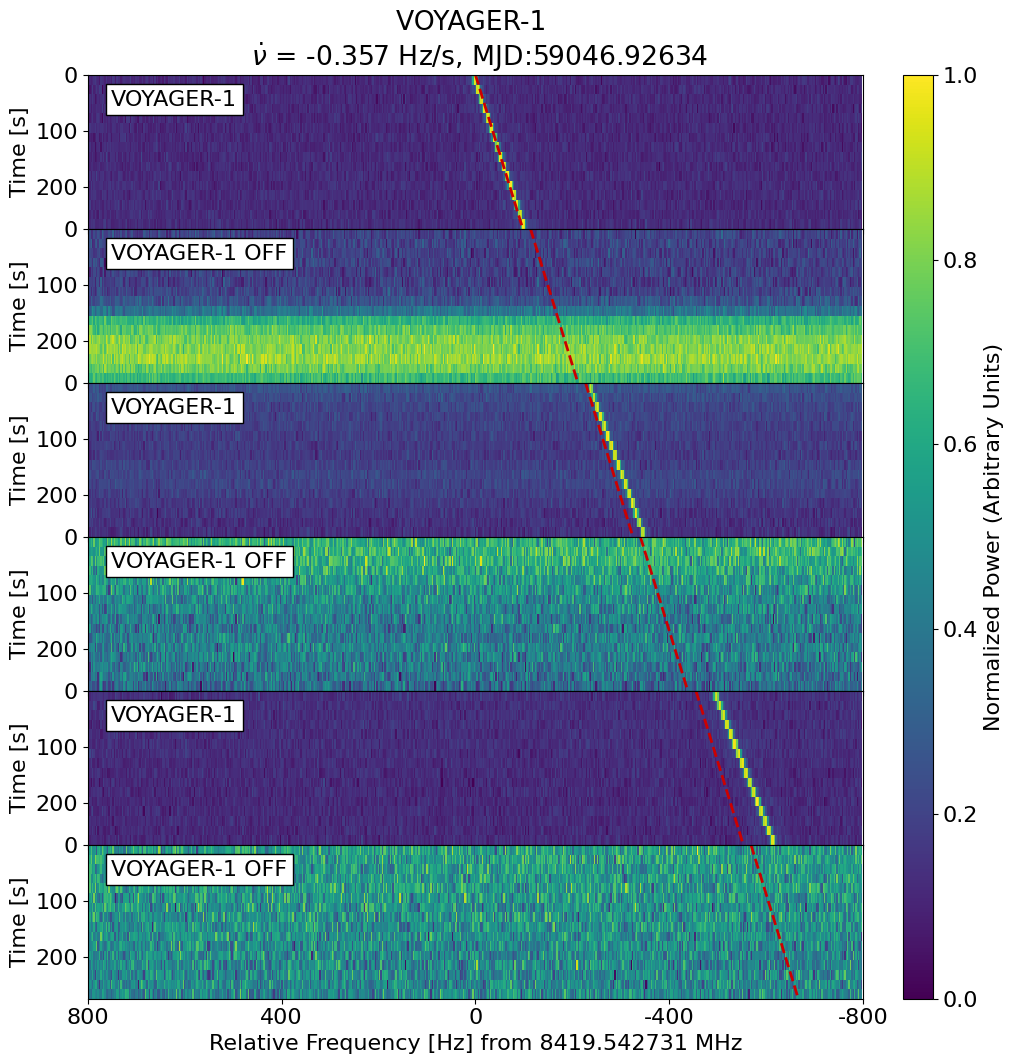

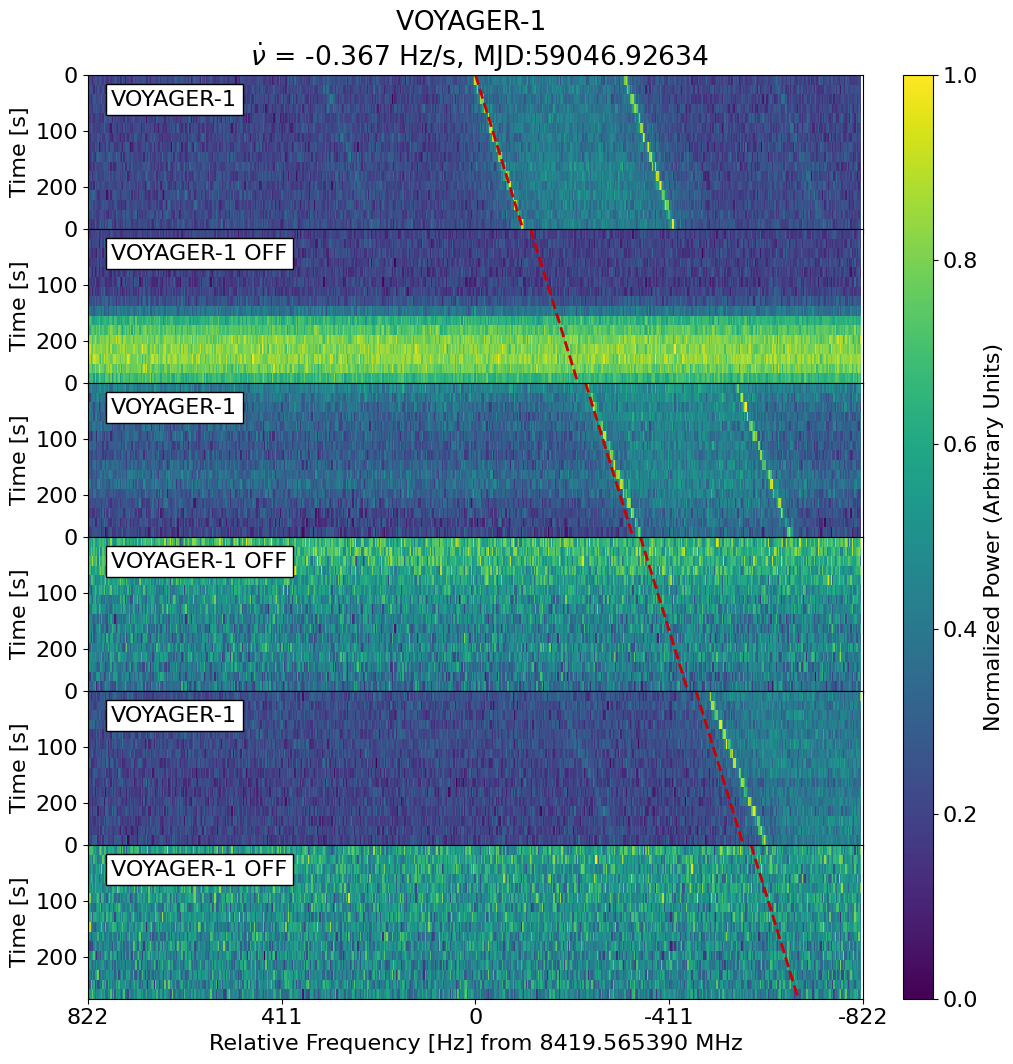

In [ ]:
pnglist=sorted(glob.glob(DATADIR + '*.png'))
print (pnglist)
for pngfile in pnglist:
    display(Image(filename=pngfile))

### Using the plotSETI command line executable for finding and plotting events

In [ ]:
print("tutorial_1: Please wait for the \"End\" message,\n")
console = "plotSETI -f 3 -o " + DATADIR + " " + DATADIR
os.system(console)
print("\ntutorial_1: All PNG files have been generated.")
print("tutorial_1: End.")

tutorial_1: Please wait for the "End" message,

plotSETI: Directory of h5 files: /Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/
plotSETI: Directory of dat files: /Users/karenp31/Documents/BL_SETI/BLING_Kickoff/turbo_seti_data/
plotSETI: Found 6 h5 files.
plotSETI: Found 6 dat files.

===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
find_event_pipeline INFO     file=single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat, tstart=59046.92634259259, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat, tstart=59046.93002314815, source_name=VOYAGER-1 OFF, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     file=single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat, tstart=59046.933703703704, source_name=VOYAGER-1, fch1